# Transformer IY010_simulation_7 Analysis: Varying 1 stat, fixing 2 stats

Visualise results when we vary 1 stat target at a time, use SVM, LSTM and transformer to classify the data.

Models used:
- SVM: RBF Kernel
- LSTM: IY001A
- Transformer: Full Transformer

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import glob
from pathlib import Path
from typing import Dict, Optional
import sys
import os
import re
from collections import defaultdict
import torch
import time
import matplotlib.pyplot as plt

# Add src directory to Python path
sys.path.append(str(Path.cwd().parent.parent.parent / "src"))

# Import custom modules
from classifiers.svm_classifier import svm_classifier, grid_search_svm
from classifiers.lstm_classifier import lstm_classifier
from classifiers.transformer_classifier import transformer_classifier
from models.TF_transformer import TFTransformer, ModelCfg
from utils.data_processing import add_binary_labels, add_nearest_neighbour_labels
from utils.standardise_time_series import standardise_time_series
from utils.shuffle_time_series import shuffle_time_series
from utils.load_data import load_and_split_data

# Import sklearn modules for SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

In [2]:
# Initialize results storage
results_dict = {
    'parameter': [],
    'svm_original_accuracy': [],
    'svm_shuffled_accuracy': [],
    'lstm_original_accuracy': [],
    'lstm_shuffled_accuracy': [],
    'transformer_original_accuracy': [],
    'transformer_shuffled_accuracy': []
}

Changing ``t_ac_target``:

In [3]:
##### Set up directory paths for data loading ######
BASE_DIR = Path.cwd().parent
OUT_DIR = BASE_DIR
SYNTHETIC_DIR = BASE_DIR / "data_7_mu_cv_fixed" 
RESULTS_CSV = "IY010_simulation_parameters_7_mu_cv_fixed.csv"
results_csv_path = BASE_DIR / RESULTS_CSV
results = pd.read_csv(results_csv_path)
results = results[results["success"]].dropna(
    subset=["mu_observed", "cv_observed", "t_ac_observed"]
)

label_column = 't_ac_target' 
labelled_results = add_binary_labels(results, label_column)
# labelled_results = add_nearest_neighbour_labels(results, positive_on=label_column)
##### Set up directory paths for data loading ######

##### Use standardise_time_series utility function ######
# Collect all DataFrames and their labels
data_frames = []
labels = []

for i in range(len(results)):
    trajectory_filename = results["trajectory_filename"].values[i]
    DATA_CSV = SYNTHETIC_DIR / trajectory_filename
    data = pd.read_csv(DATA_CSV)
    data_frames.append(data)
    
    # Get the corresponding label from the results csv
    label_value = labelled_results[labelled_results['trajectory_filename'] == trajectory_filename]['label'].iloc[0]
    labels.append(label_value)

# Use the utility function to standardize
labelled_data = standardise_time_series(data_frames, labels=labels, prefix="t_")

print(f"📏 Standardized dataset:")
print(f"   NaN values: {labelled_data.isnull().sum().sum()}")
##### Use standardise_time_series utility function ######

# Save to temporary file for load_and_split_data function
temp_path = BASE_DIR / "temp_t_ac_target.csv"
labelled_data.to_csv(temp_path, index=False)

# Use load_and_split_data for consistent splitting
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(
    temp_path, split_val_size=0.2
)

print(f"Data preparation:")
print(f"  Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")
print(f"  Train labels: {y_train.shape}, Val labels: {y_val.shape}, Test labels: {y_test.shape}")

# =========================================================
# SVM Classification
# =========================================================
print("\n🤖 SVM Classification (Original Data)")
start_time = time.time()
svm_accuracy = svm_classifier(
    X_train, X_test, y_train, y_test,
    svm_C=1.0,
    svm_gamma='scale',
    svm_kernel='rbf',
    print_classification_report=True,
    print_confusion_matrix=True,
)
training_time = time.time() - start_time
print(f"⏱️  SVM training time: {training_time:.2f} seconds")

# =========================================================
# LSTM Classification
# =========================================================
print("\n🧠 LSTM Classification (Original Data)")
start_time = time.time()
# IY001A LSTM
lstm_accuracy = lstm_classifier(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    epochs=100,
    hidden_size=128,
    num_layers=4,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    use_conv1d=True,
    use_attention=True,
    num_attention_heads=4,
    use_auxiliary=True,
)
training_time = time.time() - start_time
print(f"⏱️  LSTM training time: {training_time:.2f} seconds")

# =========================================================
# Transformer Classification
# =========================================================
print("\n🤖 Transformer Classification (Original Data)")
start_time = time.time()
transformer_accuracy = transformer_classifier(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    d_model=128,
    nhead=8,
    num_layers=4,
    epochs=50,
    use_conv1d=True,
    use_auxiliary=True,
)
training_time = time.time() - start_time
print(f"⏱️  Transformer training time: {training_time:.2f} seconds")

# =========================================================
# Shuffled Data Analysis
# =========================================================
print("\n🔀 Experiment: Shuffling Time Series Data to Test Temporal Order Impact")
df = labelled_data.copy()
df_shuffled = shuffle_time_series(
    df, 
    preserve_columns=['label'], 
    random_state=42
 ,
        strategy='global'
)# Save shuffled data to temporary file

temp_shuffled_path = BASE_DIR / "temp_t_ac_target_shuffled.csv"
df_shuffled.to_csv(temp_shuffled_path, index=False)

# Load and split shuffled data
X_train_shuffled, X_val_shuffled, X_test_shuffled, y_train_shuffled, y_val_shuffled, y_test_shuffled = load_and_split_data(
    temp_shuffled_path, split_val_size=0.2
)

# SVM on shuffled data
print("\n🤖 SVM Classification (Shuffled Data)")
start_time = time.time()
svm_accuracy_shuffled = svm_classifier(
    X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled,
    svm_C=1.0,
    svm_gamma='scale',
    svm_kernel='rbf',
    print_classification_report=True,
    print_confusion_matrix=True,
)
training_time = time.time() - start_time
print(f"⏱️  SVM training time: {training_time:.2f} seconds")

# LSTM on shuffled data
print("\n🧠 LSTM Classification (Shuffled Data)")
start_time = time.time()
lstm_accuracy_shuffled = lstm_classifier(
    X_train_shuffled,
    X_val_shuffled,
    X_test_shuffled,
    y_train_shuffled,
    y_val_shuffled,
    y_test_shuffled,
    epochs=100,
    hidden_size=128,
    num_layers=4,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    use_conv1d=True,
    use_attention=True,
    num_attention_heads=4,
    use_auxiliary=True,
)
training_time = time.time() - start_time
print(f"⏱️  LSTM training time: {training_time:.2f} seconds")

# Transformer on shuffled data
print("\n🤖 Transformer Classification (Shuffled Data)")
start_time = time.time()
transformer_accuracy_shuffled = transformer_classifier(
    X_train_shuffled,
    X_val_shuffled,
    X_test_shuffled,
    y_train_shuffled,
    y_val_shuffled,
    y_test_shuffled,
    d_model=128,
    nhead=8,
    num_layers=4,
    epochs=50,
    use_conv1d=True,
    use_auxiliary=True,
)
training_time = time.time() - start_time
print(f"⏱️  Transformer training time: {training_time:.2f} seconds")

# Store results
results_dict['parameter'].append('Autocorrelation Time')
results_dict['svm_original_accuracy'].append(svm_accuracy)
results_dict['svm_shuffled_accuracy'].append(svm_accuracy_shuffled)
results_dict['lstm_original_accuracy'].append(lstm_accuracy)
results_dict['lstm_shuffled_accuracy'].append(lstm_accuracy_shuffled)
results_dict['transformer_original_accuracy'].append(transformer_accuracy)
results_dict['transformer_shuffled_accuracy'].append(transformer_accuracy_shuffled)

# Clean up temporary files
os.remove(temp_path)
os.remove(temp_shuffled_path)

📏 Standardized dataset:
   NaN values: 0
Data preparation:
  Train shape: (6016, 174), Val shape: (1504, 174), Test shape: (1880, 174)
  Train labels: (6016,), Val labels: (1504,), Test labels: (1880,)

🤖 SVM Classification (Original Data)
=== SVM (RBF Kernel) Classification Accuracy: 0.83 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       920
           1       0.77      0.94      0.85       960

    accuracy                           0.83      1880
   macro avg       0.85      0.83      0.83      1880
weighted avg       0.84      0.83      0.83      1880


Confusion Matrix:
[[656 264]
 [ 58 902]]
⏱️  SVM training time: 2.45 seconds

🧠 LSTM Classification (Original Data)
=== LSTM with Conv1D and 4-Head Attention Accuracy: 1.00 ===
⏱️  LSTM training time: 45.18 seconds

🤖 Transformer Classification (Original Data)
=== Transformer with Conv1D and Auxiliary Task Accuracy: 1.00 ===
⏱️  Transformer training t

In [5]:
from classifiers.random_forest_classifier import random_forest_classifier
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
# TODO

=== Random Forest Accuracy: 1.00 ===


Changing ``cv_target``:

In [4]:
##### Set up directory paths for data loading ######
BASE_DIR = Path.cwd().parent
OUT_DIR = BASE_DIR
SYNTHETIC_DIR = BASE_DIR / "data_7_mu_t_ac_fixed" 
RESULTS_CSV = "IY010_simulation_parameters_7_mu_t_ac_fixed.csv"
results_csv_path = BASE_DIR / RESULTS_CSV
results = pd.read_csv(results_csv_path)
results = results[results["success"]].dropna(
    subset=["mu_observed", "cv_observed", "t_ac_observed"]
)

label_column = "cv_target" 
labelled_results = add_binary_labels(results, label_column)
# labelled_results = add_nearest_neighbour_labels(results, positive_on=label_column)
##### Set up directory paths for data loading ######

##### Use standardise_time_series utility function ######
# Collect all DataFrames and their labels
data_frames = []
labels = []

for i in range(len(results)):
    trajectory_filename = results["trajectory_filename"].values[i]
    DATA_CSV = SYNTHETIC_DIR / trajectory_filename
    data = pd.read_csv(DATA_CSV)
    data_frames.append(data)
    
    # Get the corresponding label from the results csv
    label_value = labelled_results[labelled_results['trajectory_filename'] == trajectory_filename]['label'].iloc[0]
    labels.append(label_value)

# Use the utility function to standardize
labelled_data = standardise_time_series(data_frames, labels=labels, prefix="t_")

print(f"📏 Standardized dataset:")
print(f"   NaN values: {labelled_data.isnull().sum().sum()}")
##### Use standardise_time_series utility function ######

# Save to temporary file for load_and_split_data function
temp_path = BASE_DIR / "temp_cv_target.csv"
labelled_data.to_csv(temp_path, index=False)

# Use load_and_split_data for consistent splitting
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(
    temp_path, split_val_size=0.2
)

print(f"Data preparation:")
print(f"  Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

# =========================================================
# SVM Classification
# =========================================================
print("\n🤖 SVM Classification (Original Data)")
svm_accuracy = svm_classifier(
    X_train, X_test, y_train, y_test,
    svm_C=1.0,
    svm_gamma='scale',
    svm_kernel='rbf',
    print_classification_report=True,
    print_confusion_matrix=True,
)

# =========================================================
# LSTM Classification
# =========================================================
print("\n🧠 LSTM Classification (Original Data)")
lstm_accuracy = lstm_classifier(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    epochs=100,
    hidden_size=128,
    num_layers=4,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    use_conv1d=True,
    use_attention=True,
    num_attention_heads=4,
    use_auxiliary=True,
)

# =========================================================
# Transformer Classification
# =========================================================
print("\n🤖 Transformer Classification (Original Data)")
transformer_accuracy = transformer_classifier(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    d_model=128,
    nhead=8,
    num_layers=4,
    epochs=50,
    use_conv1d=True,
    use_auxiliary=True,
)

# =========================================================
# Shuffled Data Analysis
# =========================================================
print("\n🔀 Experiment: Shuffling Time Series Data to Test Temporal Order Impact")
df = labelled_data.copy()
df_shuffled = shuffle_time_series(
    df, 
    preserve_columns=['label'], 
    random_state=42
 ,
        strategy='global'
)# Save shuffled data to temporary file

temp_shuffled_path = BASE_DIR / "temp_cv_target_shuffled.csv"
df_shuffled.to_csv(temp_shuffled_path, index=False)

# Load and split shuffled data
X_train_shuffled, X_val_shuffled, X_test_shuffled, y_train_shuffled, y_val_shuffled, y_test_shuffled = load_and_split_data(
    temp_shuffled_path, split_val_size=0.2
)

# SVM on shuffled data
print("\n🤖 SVM Classification (Shuffled Data)")
svm_accuracy_shuffled = svm_classifier(
    X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled,
    svm_C=1.0,
    svm_gamma='scale',
    svm_kernel='rbf',
    print_classification_report=True,
    print_confusion_matrix=True,
)

# LSTM on shuffled data
print("\n🧠 LSTM Classification (Shuffled Data)")
lstm_accuracy_shuffled = lstm_classifier(
    X_train_shuffled,
    X_val_shuffled,
    X_test_shuffled,
    y_train_shuffled,
    y_val_shuffled,
    y_test_shuffled,
    epochs=100,
    hidden_size=128,
    num_layers=4,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    use_conv1d=True,
    use_attention=True,
    num_attention_heads=4,
    use_auxiliary=True,
)

# Transformer on shuffled data
print("\n🤖 Transformer Classification (Shuffled Data)")
transformer_accuracy_shuffled = transformer_classifier(
    X_train_shuffled,
    X_val_shuffled,
    X_test_shuffled,
    y_train_shuffled,
    y_val_shuffled,
    y_test_shuffled,
    d_model=128,
    nhead=8,
    num_layers=4,
    epochs=50,
    use_conv1d=True,
    use_auxiliary=True,
)

# Store results
results_dict['parameter'].append('CV')
results_dict['svm_original_accuracy'].append(svm_accuracy)
results_dict['svm_shuffled_accuracy'].append(svm_accuracy_shuffled)
results_dict['lstm_original_accuracy'].append(lstm_accuracy)
results_dict['lstm_shuffled_accuracy'].append(lstm_accuracy_shuffled)
results_dict['transformer_original_accuracy'].append(transformer_accuracy)
results_dict['transformer_shuffled_accuracy'].append(transformer_accuracy_shuffled)

# Clean up temporary files
os.remove(temp_path)
os.remove(temp_shuffled_path)

📏 Standardized dataset:
   NaN values: 0
Data preparation:
  Train shape: (6144, 194), Val shape: (1536, 194), Test shape: (1920, 194)

🤖 SVM Classification (Original Data)
=== SVM (RBF Kernel) Classification Accuracy: 0.92 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       960
           1       0.92      0.93      0.93       960

    accuracy                           0.92      1920
   macro avg       0.92      0.92      0.92      1920
weighted avg       0.92      0.92      0.92      1920


Confusion Matrix:
[[880  80]
 [ 65 895]]

🧠 LSTM Classification (Original Data)
=== LSTM with Conv1D and 4-Head Attention Accuracy: 1.00 ===

🤖 Transformer Classification (Original Data)
=== Transformer with Conv1D and Auxiliary Task Accuracy: 1.00 ===

🔀 Experiment: Shuffling Time Series Data to Test Temporal Order Impact

🤖 SVM Classification (Shuffled Data)
=== SVM (RBF Kernel) Classification Accuracy: 0.93 ===

C

In [5]:
##### Set up directory paths for data loading ######
BASE_DIR = Path.cwd().parent
OUT_DIR = BASE_DIR
SYNTHETIC_DIR = BASE_DIR / "data_7_cv_t_ac_fixed" 
RESULTS_CSV = "IY010_simulation_parameters_7_cv_t_ac_fixed.csv"
results_csv_path = BASE_DIR / RESULTS_CSV
results = pd.read_csv(results_csv_path)
results = results[results["success"]].dropna(
    subset=["mu_observed", "cv_observed", "t_ac_observed"]
)

label_column = "mu_target" 
labelled_results = add_binary_labels(results, label_column)
# labelled_results = add_nearest_neighbour_labels(results, positive_on=label_column)
##### Set up directory paths for data loading ######

##### Use standardise_time_series utility function ######
# Collect all DataFrames and their labels
data_frames = []
labels = []

for i in range(len(results)):
    trajectory_filename = results["trajectory_filename"].values[i]
    DATA_CSV = SYNTHETIC_DIR / trajectory_filename
    data = pd.read_csv(DATA_CSV)
    data_frames.append(data)
    
    # Get the corresponding label from the results csv
    label_value = labelled_results[labelled_results['trajectory_filename'] == trajectory_filename]['label'].iloc[0]
    labels.append(label_value)

# Use the utility function to standardize
labelled_data = standardise_time_series(data_frames, labels=labels, prefix="t_")

print(f"📏 Standardized dataset:")
print(f"   NaN values: {labelled_data.isnull().sum().sum()}")
##### Use standardise_time_series utility function ######

# Save to temporary file for load_and_split_data function
temp_path = BASE_DIR / "temp_mu_target.csv"
labelled_data.to_csv(temp_path, index=False)

# Use load_and_split_data for consistent splitting
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(
    temp_path, split_val_size=0.2
)

print(f"Data preparation:")
print(f"  Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

# =========================================================
# SVM Classification
# =========================================================
print("\n🤖 SVM Classification (Original Data)")
svm_accuracy = svm_classifier(
    X_train, X_test, y_train, y_test,
    svm_C=1.0,
    svm_gamma='scale',
    svm_kernel='rbf',
    print_classification_report=True,
    print_confusion_matrix=True,
)

# =========================================================
# LSTM Classification
# =========================================================
print("\n🧠 LSTM Classification (Original Data)")
lstm_accuracy = lstm_classifier(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    epochs=100,
    hidden_size=128,
    num_layers=4,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    use_conv1d=True,
    use_attention=True,
    num_attention_heads=4,
    use_auxiliary=True,
)

# =========================================================
# Transformer Classification
# =========================================================
print("\n🤖 Transformer Classification (Original Data)")
transformer_accuracy = transformer_classifier(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    d_model=128,
    nhead=8,
    num_layers=4,
    epochs=50,
    use_conv1d=True,
    use_auxiliary=True,
)

# =========================================================
# Shuffled Data Analysis
# =========================================================
print("\n🔀 Experiment: Shuffling Time Series Data to Test Temporal Order Impact")
df = labelled_data.copy()
df_shuffled = shuffle_time_series(
    df, 
    preserve_columns=['label'], 
    random_state=42
 ,
        strategy='global'
)# Save shuffled data to temporary file

temp_shuffled_path = BASE_DIR / "temp_mu_target_shuffled.csv"
df_shuffled.to_csv(temp_shuffled_path, index=False)

# Load and split shuffled data
X_train_shuffled, X_val_shuffled, X_test_shuffled, y_train_shuffled, y_val_shuffled, y_test_shuffled = load_and_split_data(
    temp_shuffled_path, split_val_size=0.2
)

# SVM on shuffled data
print("\n🤖 SVM Classification (Shuffled Data)")
svm_accuracy_shuffled = svm_classifier(
    X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled,
    svm_C=1.0,
    svm_gamma='scale',
    svm_kernel='rbf',
    print_classification_report=True,
    print_confusion_matrix=True,
)

# LSTM on shuffled data
print("\n🧠 LSTM Classification (Shuffled Data)")
lstm_accuracy_shuffled = lstm_classifier(
    X_train_shuffled,
    X_val_shuffled,
    X_test_shuffled,
    y_train_shuffled,
    y_val_shuffled,
    y_test_shuffled,
    epochs=100,
    hidden_size=128,
    num_layers=4,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    use_conv1d=True,
    use_attention=True,
    num_attention_heads=4,
    use_auxiliary=True,
)

# Transformer on shuffled data
print("\n🤖 Transformer Classification (Shuffled Data)")
transformer_accuracy_shuffled = transformer_classifier(
    X_train_shuffled,
    X_val_shuffled,
    X_test_shuffled,
    y_train_shuffled,
    y_val_shuffled,
    y_test_shuffled,
    d_model=128,
    nhead=8,
    num_layers=4,
    epochs=50,
    use_conv1d=True,
    use_auxiliary=True,
)

# Store results
results_dict['parameter'].append('Mean')
results_dict['svm_original_accuracy'].append(svm_accuracy)
results_dict['svm_shuffled_accuracy'].append(svm_accuracy_shuffled)
results_dict['lstm_original_accuracy'].append(lstm_accuracy)
results_dict['lstm_shuffled_accuracy'].append(lstm_accuracy_shuffled)
results_dict['transformer_original_accuracy'].append(transformer_accuracy)
results_dict['transformer_shuffled_accuracy'].append(transformer_accuracy_shuffled)

# Clean up temporary files
os.remove(temp_path)
os.remove(temp_shuffled_path)

📏 Standardized dataset:
   NaN values: 0
Data preparation:
  Train shape: (2560, 194), Val shape: (640, 194), Test shape: (800, 194)

🤖 SVM Classification (Original Data)
=== SVM (RBF Kernel) Classification Accuracy: 0.89 ===

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       400
           1       0.91      0.86      0.89       400

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800


Confusion Matrix:
[[366  34]
 [ 54 346]]

🧠 LSTM Classification (Original Data)
=== LSTM with Conv1D and 4-Head Attention Accuracy: 1.00 ===

🤖 Transformer Classification (Original Data)
=== Transformer with Conv1D and Auxiliary Task Accuracy: 1.00 ===

🔀 Experiment: Shuffling Time Series Data to Test Temporal Order Impact

🤖 SVM Classification (Shuffled Data)
=== SVM (RBF Kernel) Classification Accuracy: 0.89 ===

Cla

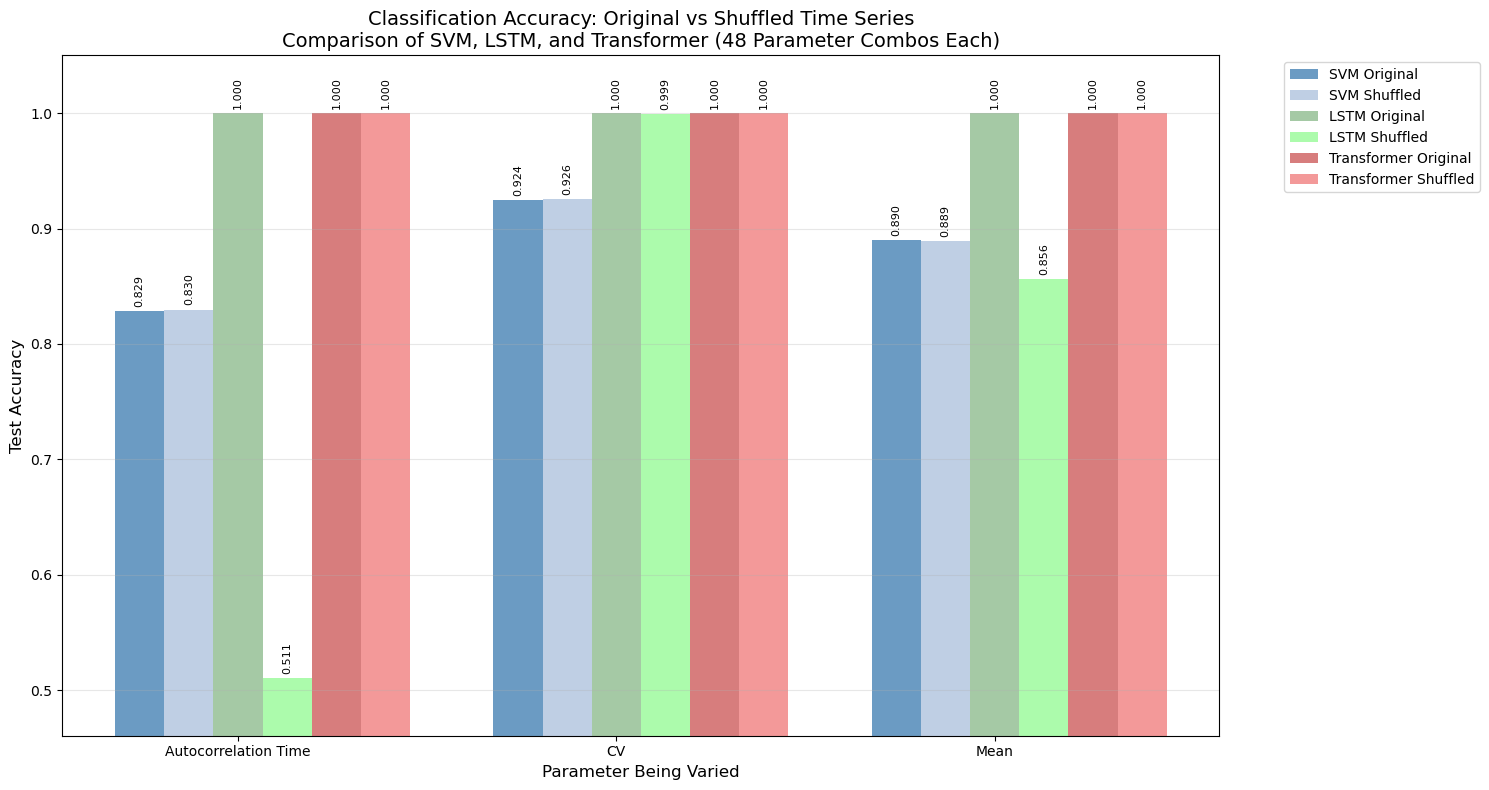


📊 Classification Accuracy Summary:

Autocorrelation Time:
  SVM:         Original: 0.829 | Shuffled: 0.830 | Diff: -0.001
  LSTM:        Original: 1.000 | Shuffled: 0.511 | Diff: +0.489
  Transformer: Original: 1.000 | Shuffled: 1.000 | Diff: +0.000

CV:
  SVM:         Original: 0.924 | Shuffled: 0.926 | Diff: -0.001
  LSTM:        Original: 1.000 | Shuffled: 0.999 | Diff: +0.001
  Transformer: Original: 1.000 | Shuffled: 1.000 | Diff: +0.000

Mean:
  SVM:         Original: 0.890 | Shuffled: 0.889 | Diff: +0.001
  LSTM:        Original: 1.000 | Shuffled: 0.856 | Diff: +0.144
  Transformer: Original: 1.000 | Shuffled: 1.000 | Diff: +0.000

Average differences (Original - Shuffled):
  SVM:         -0.000
  LSTM:        0.211
  Transformer: 0.000


In [6]:
# =========================================================
# Plot Results: Classification Accuracy Comparison Across Parameters
# =========================================================

# Create DataFrame from results
results_df = pd.DataFrame(results_dict)

# Set up the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Define x-axis positions
x_positions = np.arange(len(results_df['parameter']))
width = 0.13  # Width of bars

# Create bars for each classifier
bars1 = ax.bar(x_positions - 2*width, results_df['svm_original_accuracy'], 
               width, label='SVM Original', alpha=0.8, color='steelblue')
bars2 = ax.bar(x_positions - width, results_df['svm_shuffled_accuracy'], 
               width, label='SVM Shuffled', alpha=0.8, color='lightsteelblue')
bars3 = ax.bar(x_positions, results_df['lstm_original_accuracy'], 
               width, label='LSTM Original', alpha=0.8, color='darkseagreen')
bars4 = ax.bar(x_positions + width, results_df['lstm_shuffled_accuracy'], 
               width, label='LSTM Shuffled', alpha=0.8, color='palegreen')
bars5 = ax.bar(x_positions + 2*width, results_df['transformer_original_accuracy'], 
               width, label='Transformer Original', alpha=0.8, color='indianred')
bars6 = ax.bar(x_positions + 3*width, results_df['transformer_shuffled_accuracy'], 
               width, label='Transformer Shuffled', alpha=0.8, color='lightcoral')

# Customize the plot
ax.set_xlabel('Parameter Being Varied', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Classification Accuracy: Original vs Shuffled Time Series\nComparison of SVM, LSTM, and Transformer (48 Parameter Combos Each)', fontsize=14)
ax.set_xticks(x_positions)
ax.set_xticklabels(results_df['parameter'])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=8, rotation=90)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)
add_value_labels(bars5)
add_value_labels(bars6)

# Set y-axis limits to better show differences
all_accuracies = (results_df['svm_original_accuracy'].tolist() + 
                 results_df['svm_shuffled_accuracy'].tolist() +
                 results_df['lstm_original_accuracy'].tolist() + 
                 results_df['lstm_shuffled_accuracy'].tolist() +
                 results_df['transformer_original_accuracy'].tolist() + 
                 results_df['transformer_shuffled_accuracy'].tolist())
y_min = min(all_accuracies) - 0.05
y_max = max(all_accuracies) + 0.05
ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Classification Accuracy Summary:")
print("="*80)
for i, row in results_df.iterrows():
    param = row['parameter']
    print(f"\n{param}:")
    print(f"  SVM:         Original: {row['svm_original_accuracy']:.3f} | Shuffled: {row['svm_shuffled_accuracy']:.3f} | Diff: {row['svm_original_accuracy'] - row['svm_shuffled_accuracy']:+.3f}")
    print(f"  LSTM:        Original: {row['lstm_original_accuracy']:.3f} | Shuffled: {row['lstm_shuffled_accuracy']:.3f} | Diff: {row['lstm_original_accuracy'] - row['lstm_shuffled_accuracy']:+.3f}")
    print(f"  Transformer: Original: {row['transformer_original_accuracy']:.3f} | Shuffled: {row['transformer_shuffled_accuracy']:.3f} | Diff: {row['transformer_original_accuracy'] - row['transformer_shuffled_accuracy']:+.3f}")

print(f"\nAverage differences (Original - Shuffled):")
print(f"  SVM:         {np.mean(results_df['svm_original_accuracy'] - results_df['svm_shuffled_accuracy']):.3f}")
print(f"  LSTM:        {np.mean(results_df['lstm_original_accuracy'] - results_df['lstm_shuffled_accuracy']):.3f}")
print(f"  Transformer: {np.mean(results_df['transformer_original_accuracy'] - results_df['transformer_shuffled_accuracy']):.3f}")

Plot time series showing a set of data with **extremely high t_ac value** and **extremely low t_ac value**, to illustrate how simple the classification problem is. Both in the original and shuffled form.

In [7]:
# =========================================================
# Plot Original vs Shuffled Time Series for t_ac_target Dataset
# =========================================================

# First, reload the t_ac_target dataset to get the original time series
BASE_DIR = Path.cwd().parent
SYNTHETIC_DIR = BASE_DIR / "data_7_mu_cv_fixed" 
RESULTS_CSV = "IY010_simulation_parameters_7_mu_cv_fixed.csv"
results_csv_path = BASE_DIR / RESULTS_CSV
results = pd.read_csv(results_csv_path)
results = results[results["success"]].dropna(
    subset=["mu_observed", "cv_observed", "t_ac_observed"]
)

# load the dataset where t_ac_observed is the highest and where t_observed is lowest
highest_t_ac_df = results.loc[results['t_ac_observed'].idxmax()]
lowest_t_ac_df = results.loc[results['t_ac_observed'].idxmin()]
# combine them horizontally
highest_lowest_results = pd.DataFrame([highest_t_ac_df, lowest_t_ac_df])
highest_lowest_results.index = ['highest_t_ac', 'lowest_t_ac']
highest_lowest_results

,mu_target,t_ac_target,cv_target,sigma_sum,success,error_message,rho,d,sigma_b,sigma_u,mu_observed,cv_observed,t_ac_observed,variance_observed,mean_rel_error_pct,cv_rel_error_pct,t_ac_rel_error_pct,trajectory_filename
highest_t_ac,1000,98.754398,1.0,1,True,NaN,1019.450076,0.010230,0.010035,0.989965,967.496516,1.012965,97.215493,960478.842246,3.250348,1.296512,1.558316,mRNA_trajectories_1000.000_1.000_98.754.csv
lowest_t_ac,1000,2.998227,1.0,1,True,NaN,2092.180747,0.546864,0.261385,0.738615,989.514679,1.004858,2.942832,988675.741067,1.048532,0.485801,1.847601,mRNA_trajectories_1000.000_1.000_2.998.csv


In [10]:
label_column = 't_ac_target' 
labelled_results = add_binary_labels(highest_lowest_results, label_column)

# Collect all DataFrames and their labels
data_frames = []
labels = []

for i in range(len(highest_lowest_results)):
    trajectory_filename = highest_lowest_results["trajectory_filename"].iloc[i]
    DATA_CSV = SYNTHETIC_DIR / trajectory_filename
    data = pd.read_csv(DATA_CSV)
    data_frames.append(data)
    
    # Get the corresponding label from the results csv
    label_value = labelled_results[labelled_results['trajectory_filename'] == trajectory_filename]['label'].iloc[0]
    labels.append(label_value)

# Use the utility function to standardize
labelled_data = standardise_time_series(data_frames, labels=labels, prefix="t_")

# Get original time series
df = labelled_data.copy()
y = df["label"].values
X = df.drop(columns=["label"]).values

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=TEST_SPLIT, 
#     random_state=RANDOM_STATE,
#     stratify=y  # Ensure balanced split across classes
# )
# # Train SVM on original data
# svm_accuracy = svm_classifier(
#     X_train, X_test, y_train, y_test,
#     svm_C=SVM_C,
#     svm_gamma=SVM_GAMMA, 
#     svm_kernel=SVM_KERNEL,
#     print_classification_report=True,
#     print_confusion_matrix=True,
# )

# Get shuffled time series
RANDOM_STATE = 42

df_shuffled = shuffle_time_series(
    df,
    preserve_columns=['label'],
    random_state=RANDOM_STATE,
    strategy='global'
)

y_shuffled = df_shuffled["label"].values
X_shuffled = df_shuffled.drop(columns=["label"]).values


# X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled = train_test_split(
#     X_shuffled, 
#     y_shuffled, 
#     test_size=TEST_SPLIT,
#     random_state=RANDOM_STATE,
#     stratify=y_shuffled
# )
# # Train SVM on shuffled data
# svm_accuracy_shuffled = svm_classifier(
#     X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled,
#     svm_C=SVM_C,
#     svm_gamma=SVM_GAMMA, 
#     svm_kernel=SVM_KERNEL,
#     print_classification_report=True,
#     print_confusion_matrix=True,
# )

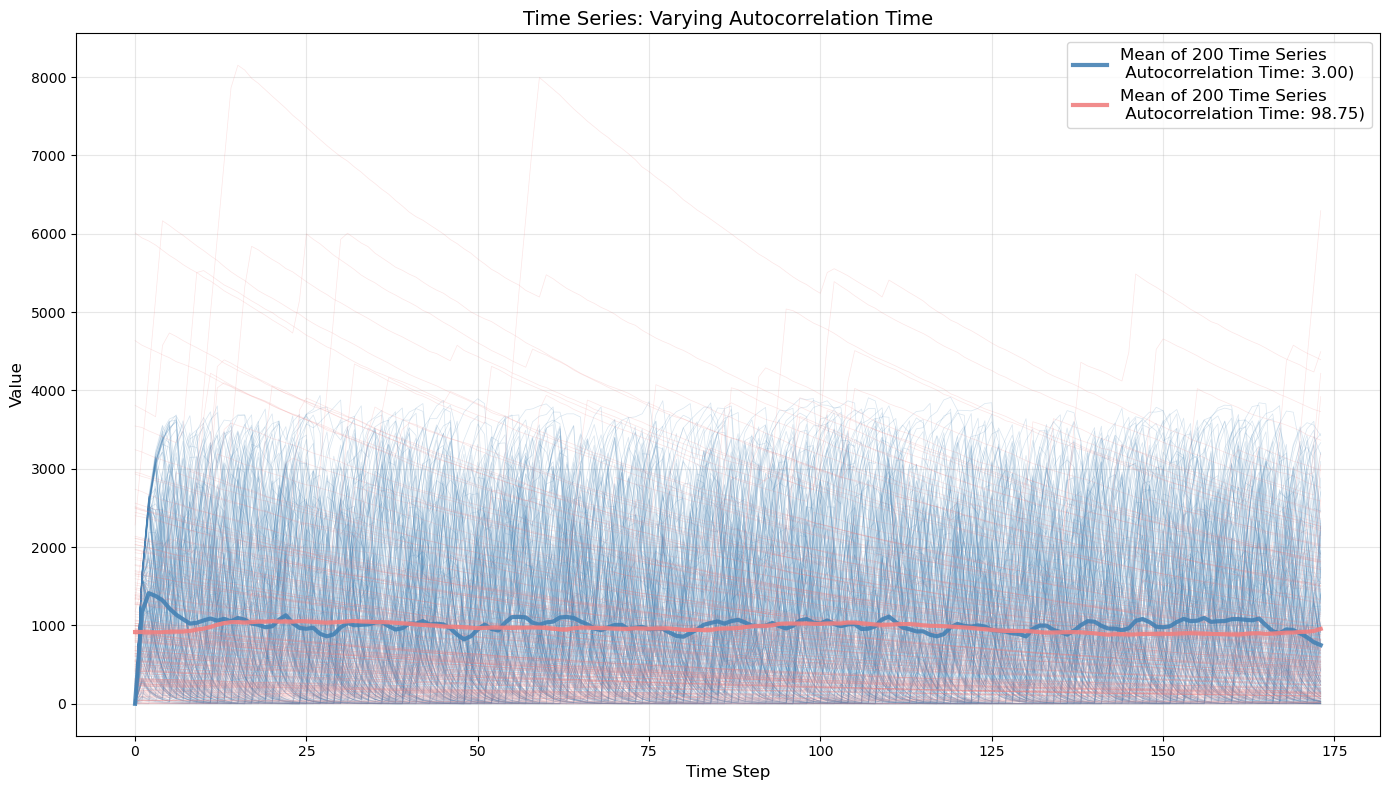

📊 Class Statistics:
Class 0: 200 time series
Class 1: 200 time series
Class 0 mean range: [0.000, 1412.290]
Class 1 mean range: [882.575, 1058.425]
Mean difference between classes: 84.473


In [12]:
# # =========================================================
# Plot Mean Time Series by Class with Individual Series in Background
# =========================================================

# Separate time series by class
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

X_class_0 = X[class_0_indices]
X_class_1 = X[class_1_indices]

# Calculate means
mean_class_0 = np.mean(X_class_0, axis=0)
mean_class_1 = np.mean(X_class_1, axis=0)

# get the corresponding Autocorrelation Time values
t_ac_class_0 = lowest_t_ac_df['t_ac_target']
t_ac_class_1 = highest_t_ac_df['t_ac_target']

time_steps = np.arange(X.shape[1])

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot individual time series in background (transparent)
for i in range(len(X_class_0)):
    ax.plot(time_steps, X_class_0[i], color='steelblue', alpha=0.2, linewidth=0.5)

for i in range(len(X_class_1)):
    ax.plot(time_steps, X_class_1[i], color='lightcoral', alpha=0.2, linewidth=0.5)

# Plot mean time series (bold)
ax.plot(time_steps, mean_class_0, color='steelblue', linewidth=3, 
        label=f'Mean of {len(X_class_0)} Time Series\n Autocorrelation Time: {t_ac_class_0:.2f})', alpha=0.9)
ax.plot(time_steps, mean_class_1, color='lightcoral', linewidth=3, 
        label=f'Mean of {len(X_class_1)} Time Series\n Autocorrelation Time: {t_ac_class_1:.2f})', alpha=0.9)

# Customize plot
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Time Series: Varying Autocorrelation Time', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"📊 Class Statistics:")
print(f"Class 0: {len(X_class_0)} time series")
print(f"Class 1: {len(X_class_1)} time series")
print(f"Class 0 mean range: [{np.min(mean_class_0):.3f}, {np.max(mean_class_0):.3f}]")
print(f"Class 1 mean range: [{np.min(mean_class_1):.3f}, {np.max(mean_class_1):.3f}]")
print(f"Mean difference between classes: {np.mean(np.abs(mean_class_0 - mean_class_1)):.3f}")

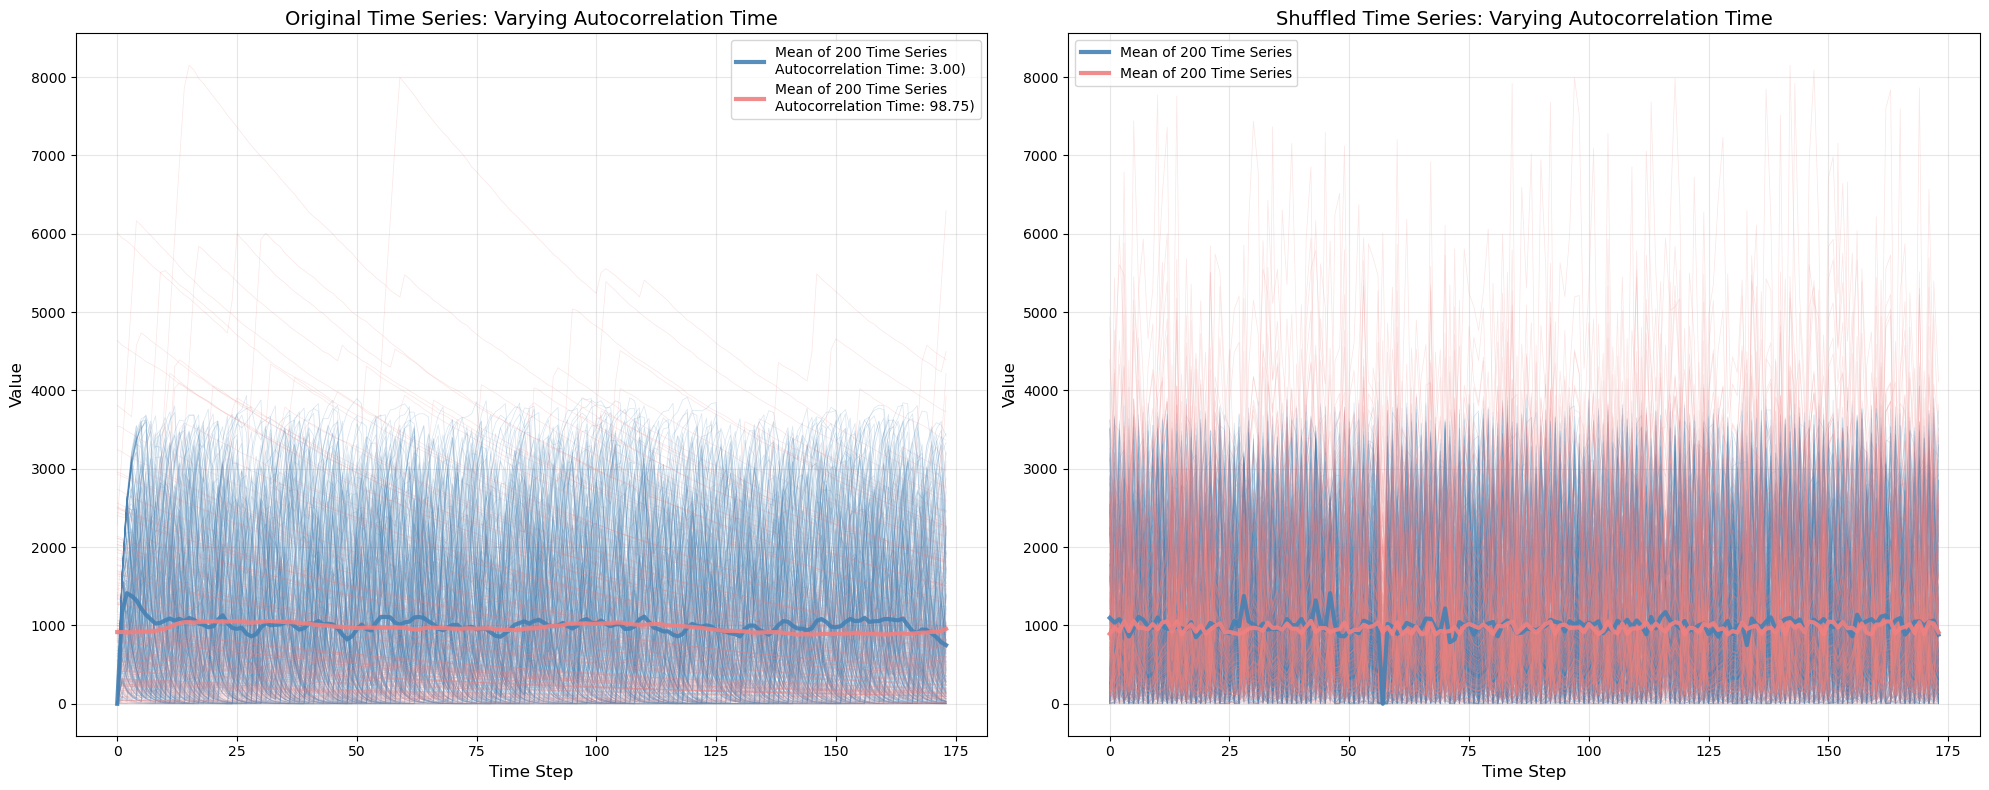

📊 Class Statistics:
Class 0: 200 time series
Class 1: 200 time series
Original - Class 0 mean range: [0.000, 1412.290]
Original - Class 1 mean range: [882.575, 1058.425]
Shuffled - Class 0 mean range: [0.000, 1412.290]
Shuffled - Class 1 mean range: [882.575, 1058.425]
Original mean difference between classes: 84.473
Shuffled mean difference between classes: 84.473


In [14]:
# =========================================================
# Plot Mean Time Series by Class with Individual Series in Background
# =========================================================

# Separate time series by class
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

X_class_0 = X[class_0_indices]
X_class_1 = X[class_1_indices]

# Separate shuffled time series by class
X_shuffled_class_0 = X_shuffled[class_0_indices]
X_shuffled_class_1 = X_shuffled[class_1_indices]

# Calculate means
mean_class_0 = np.mean(X_class_0, axis=0)
mean_class_1 = np.mean(X_class_1, axis=0)
mean_shuffled_class_0 = np.mean(X_shuffled_class_0, axis=0)
mean_shuffled_class_1 = np.mean(X_shuffled_class_1, axis=0)

# get the corresponding t_ac values
t_ac_class_0 = lowest_t_ac_df['t_ac_target']
t_ac_class_1 = highest_t_ac_df['t_ac_target']

time_steps = np.arange(X.shape[1])

# Create the plot with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Original time series plot
# Plot individual time series in background (transparent)
for i in range(len(X_class_0)):
    ax1.plot(time_steps, X_class_0[i], color='steelblue', alpha=0.2, linewidth=0.5)

for i in range(len(X_class_1)):
    ax1.plot(time_steps, X_class_1[i], color='lightcoral', alpha=0.2, linewidth=0.5)

# Plot mean time series (bold)
ax1.plot(time_steps, mean_class_0, color='steelblue', linewidth=3, 
        label=f'Mean of {len(X_class_0)} Time Series\nAutocorrelation Time: {t_ac_class_0:.2f})', alpha=0.9)
ax1.plot(time_steps, mean_class_1, color='lightcoral', linewidth=3, 
        label=f'Mean of {len(X_class_1)} Time Series\nAutocorrelation Time: {t_ac_class_1:.2f})', alpha=0.9)

# Customize original plot
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.set_title('Original Time Series: Varying Autocorrelation Time', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Shuffled time series plot
# Plot individual shuffled time series in background (transparent)
for i in range(len(X_shuffled_class_0)):
    ax2.plot(time_steps, X_shuffled_class_0[i], color='steelblue', alpha=0.2, linewidth=0.5)

for i in range(len(X_shuffled_class_1)):
    ax2.plot(time_steps, X_shuffled_class_1[i], color='lightcoral', alpha=0.2, linewidth=0.5)

# Plot mean shuffled time series (bold)
ax2.plot(time_steps, mean_shuffled_class_0, color='steelblue', linewidth=3, 
        label=f'Mean of {len(X_shuffled_class_0)} Time Series', alpha=0.9)
ax2.plot(time_steps, mean_shuffled_class_1, color='lightcoral', linewidth=3, 
        label=f'Mean of {len(X_shuffled_class_1)} Time Series', alpha=0.9)

# Customize shuffled plot
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax2.set_title('Shuffled Time Series: Varying Autocorrelation Time', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"📊 Class Statistics:")
print(f"Class 0: {len(X_class_0)} time series")
print(f"Class 1: {len(X_class_1)} time series")
print(f"Original - Class 0 mean range: [{np.min(mean_class_0):.3f}, {np.max(mean_class_0):.3f}]")
print(f"Original - Class 1 mean range: [{np.min(mean_class_1):.3f}, {np.max(mean_class_1):.3f}]")
print(f"Shuffled - Class 0 mean range: [{np.min(mean_shuffled_class_0):.3f}, {np.max(mean_shuffled_class_0):.3f}]")
print(f"Shuffled - Class 1 mean range: [{np.min(mean_shuffled_class_1):.3f}, {np.max(mean_shuffled_class_1):.3f}]")
print(f"Original mean difference between classes: {np.mean(np.abs(mean_class_0 - mean_class_1)):.3f}")
print(f"Shuffled mean difference between classes: {np.mean(np.abs(mean_shuffled_class_0 - mean_shuffled_class_1)):.3f}")